In [60]:
import numpy as np # A package for scientific computing in Python, providing support for arrays and matrices, as well as a wide range of mathematical operations
import pandas as pd # A library for data manipulation and analysis, providing data structures like DataFrames and Series to work with tabular data.
import seaborn as sns # A data visualization library based on Matplotlib that provides a high-level interface for creating informative and attractive statistical graphics.
import matplotlib.pyplot as plt # A plotting library for creating static, interactive, and animated visualizations in Python.
import plotly.graph_objects as go # A package for creating interactive and dynamic visualizations in Python, including graphs, charts, and maps.
# import scikitplot as sklpt
import kaleido # A package for exporting static images of visualizations created with Plotly or Matplotlib.
import warnings # A library for handling warnings and exceptions in Python.
warnings.filterwarnings("ignore")


from IPython.display import display # A module that provides functions for displaying various types of data within the IPython environment.
from matplotlib import colormaps # A module that provides a collection of color maps for use in visualizations.
from plotly.subplots import make_subplots

# scipy: A library for scientific computing and statistics in Python, including tools for optimization, integration, interpolation, and more.
import scipy.stats as sts
from scipy.stats import spearmanr, chi2_contingency, kendalltau
from scipy.stats import normaltest, ttest_ind
from scipy.stats import shapiro

# sklearn: A package that provides a wide range of machine learning algorithms and tools for data preprocessing, model selection, evaluation, and more.
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix


from itertools import combinations

# Data preparation

In [61]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv", index_col=0 #sets the first column of the CSV file as the index of the dataframe 
                   , dtype = {
        'id' : int,
        'gender' : 'category', # pd.CategoricalDtype(categories=["Male", "Female"], ordered=False),
        'age' : float,
        'hypertension' : bool,
        'heart_disease' : bool,
        'ever_married' : 'category',
        'work_type' : 'category', # pd.CategoricalDtype(categories=["Private", "Self-employed", "Govt_job"], ordered=False),
        'Residence_type' : 'category', # pd.CategoricalDtype(categories=["Urban", "Rural"], ordered=False),
        'avg_glucose_level' : float,
        'bmi' : float,
        'smoking_status' : 'category', # pd.CategoricalDtype(categories=["never smoked", "smokes", "formerly smoked", "Unknown"], ordered=False),
        'stroke' : bool
    },
)

## Data exploration

In [62]:
#identify features
num_cols = ["age", "avg_glucose_level", "bmi"]
cate_cols = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]
data[cate_cols] = data[cate_cols].astype('category')

In [63]:
print(data.dtypes)
print("-"*100)
print('shape:', data.shape)
print("-"*100)
print(data.head(10))
print("-"*100)
print('missing values: ', data.isna().sum())
print("-"*100)
print(data.describe())
print("-"*100)

gender               category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                   bool
dtype: object
----------------------------------------------------------------------------------------------------
shape: (5110, 11)
----------------------------------------------------------------------------------------------------
       gender   age hypertension heart_disease ever_married      work_type  \
id                                                                           
9046     Male  67.0        False          True          Yes        Private   
51676  Female  61.0        False         False          Yes  Self-employed   
31112    Male  80.0        False          True          Yes        Private   
60182  Female  49.0        False         False

### Balance

checking if the data is balanced or not

In [64]:
#how many strokes
print(data["stroke"].value_counts())
print("-"*100)

False    4861
True      249
Name: stroke, dtype: int64
----------------------------------------------------------------------------------------------------


In [65]:
# check for missing values within the data stroke = True
filtered_data = data[(data['stroke'] == True) & (data['bmi'].isna())]
count = len(filtered_data)
print("Sum of values with stroke=True and BMI= N/A:", count)
percentage = (count / data[data["stroke"] == True]["stroke"].value_counts().loc[True]) * 100
print('This accounts for', round(percentage,2), '% of stroke = True data')

Sum of values with stroke=True and BMI= N/A: 40
This accounts for 16.06 % of stroke = True data


#### This shows that we have about 16% missing values within the True values for stroke. Since we already have very impalanced data, it is not very useful to further delete data with missing values. Therefore we decided to replace the missing values.


The Data is imbalanced! -> challenges for certain machine learning algorithms, as the model may be biased towards the majority class and struggle to learn patterns from the minority class.

This means we have to perform a stratified K-Fold when splitting the Data into Test- and Training-Data

## Data Cleaning

handling missing values, outliers, and other inconsistencies in the data

### Categorical Data

In [66]:
#unique values as overview
category_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

for column in category_columns:
    unique_categories = data[column].unique()
    print(f"Unique categories in {column}: {unique_categories}")

Unique categories in gender: ['Male', 'Female', 'Other']
Categories (3, object): ['Female', 'Male', 'Other']
Unique categories in hypertension: [False, True]
Categories (2, bool): [False, True]
Unique categories in heart_disease: [True, False]
Categories (2, bool): [False, True]
Unique categories in ever_married: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
Unique categories in work_type: ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Categories (5, object): ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']
Unique categories in Residence_type: ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
Unique categories in smoking_status: ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
Categories (4, object): ['Unknown', 'formerly smoked', 'never smoked', 'smokes']
Unique categories in stroke: [ True False]


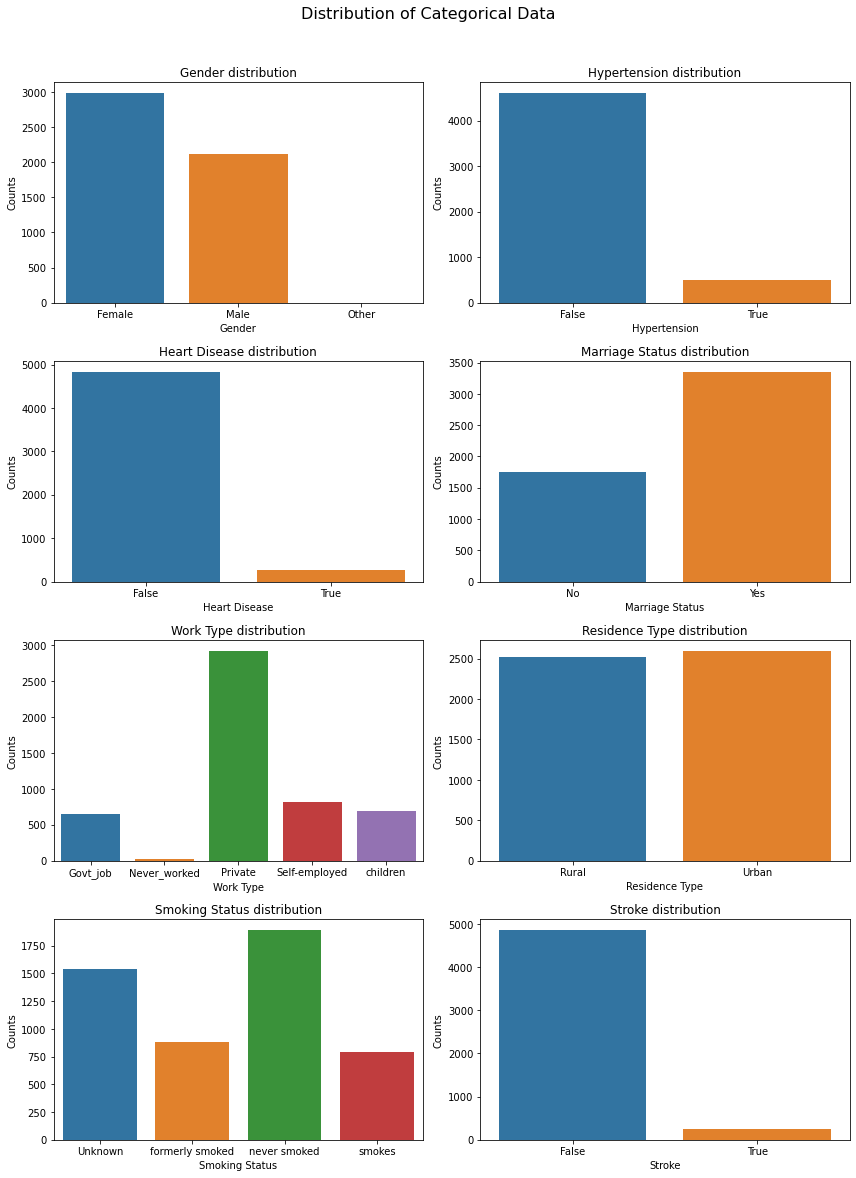

In [67]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

sns.countplot(data=data, x='gender', ax=axes[0, 0])
axes[0, 0].set(xlabel='Gender', ylabel='Counts', title='Gender distribution')

sns.countplot(data=data, x='hypertension', ax=axes[0, 1])
axes[0, 1].set(xlabel='Hypertension', ylabel='Counts', title='Hypertension distribution')

sns.countplot(data=data, x='heart_disease', ax=axes[1, 0])
axes[1, 0].set(xlabel='Heart Disease', ylabel='Counts', title='Heart Disease distribution')

sns.countplot(data=data, x='ever_married', ax=axes[1, 1])
axes[1, 1].set(xlabel='Marriage Status', ylabel='Counts', title='Marriage Status distribution')

sns.countplot(data=data, x='work_type', ax=axes[2, 0])
axes[2, 0].set(xlabel='Work Type', ylabel='Counts', title='Work Type distribution')

sns.countplot(data=data, x='Residence_type', ax=axes[2, 1])
axes[2, 1].set(xlabel='Residence Type', ylabel='Counts', title='Residence Type distribution')

sns.countplot(data=data, x='smoking_status', ax=axes[3, 0])
axes[3, 0].set(xlabel='Smoking Status', ylabel='Counts', title='Smoking Status distribution')

sns.countplot(data=data, x='stroke', ax=axes[3, 1])
axes[3, 1].set(xlabel='Stroke', ylabel='Counts', title='Stroke distribution')

plt.suptitle('Distribution of Categorical Data', fontsize=16, y=1.02)

plt.tight_layout()
plt.savefig('..\output\distribution_categorical.jpg', bbox_inches='tight')  # Save the figure with tight bounding box
plt.show()


In [68]:
# gender
print(data['gender'].value_counts())
print("-"*100)

# hypertension
print(data['hypertension'].value_counts())
print("-"*100)

# heart_disease
print(data['heart_disease'].value_counts())
print("-"*100)

# ever_married
print(data['ever_married'].value_counts())
print("-"*100)

# work_type
print(data['work_type'].value_counts())
print("-"*100)

# Residence_type
print(data['Residence_type'].value_counts())
print("-"*100)

# smoking_status
print(data['smoking_status'].value_counts())
print("-"*100)


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------
False    4612
True      498
Name: hypertension, dtype: int64
----------------------------------------------------------------------------------------------------
False    4834
True      276
Name: heart_disease, dtype: int64
----------------------------------------------------------------------------------------------------
Yes    3353
No     1757
Name: ever_married, dtype: int64
----------------------------------------------------------------------------------------------------
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
----------------------------------------------------------------------------------------------------
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
----------------------------------------

#### Cleaning the Categorical Data

In [69]:
#gender distribution has only one in the category 'other' so we can delete this category
print("Shape before cleaning 'gender'", data.shape)
other_count = data['gender'].value_counts()['Other']
print("Count of 'Other' in the 'gender' column:", other_count)
other_indices = data[data['gender'] == 'Other'].index.tolist()
print("Indices where 'Other' occurs in the 'gender' column:", other_indices)
data = data.drop(other_indices, axis=0)
data["gender"] = data["gender"].cat.remove_categories("Other")
print("-"*100)
print(data['gender'].value_counts())
print("Shape after cleaning 'gender'", data.shape)


Shape before cleaning 'gender' (5110, 11)
Count of 'Other' in the 'gender' column: 1
Indices where 'Other' occurs in the 'gender' column: [56156]
----------------------------------------------------------------------------------------------------
Female    2994
Male      2115
Name: gender, dtype: int64
Shape after cleaning 'gender' (5109, 11)


### Continuous Data

In [70]:
# age
print('min age: ', data['age'].min())
print('max age: ', data['age'].max())
print('mean age: ', data['age'].mean())
print('median age: ', data['age'].median())
print("-"*100)

# avg_glucose_level
print('min avg_glucose_level: ', data['avg_glucose_level'].min())
print('max avg_glucose_level: ', data['avg_glucose_level'].max())
print('mean avg_glucose_level: ', data['avg_glucose_level'].mean())
print('median avg_glucose_level: ', data['avg_glucose_level'].median())
print("-"*100)

# bmi
print('min bmi: ', data['bmi'].min())
print('max bmi: ', data['bmi'].max())
print('mean bmi: ', data['bmi'].mean())
print('median bmi: ', data['bmi'].median())
print("-"*100)

min age:  0.08
max age:  82.0
mean age:  43.22998629868859
median age:  45.0
----------------------------------------------------------------------------------------------------
min avg_glucose_level:  55.12
max avg_glucose_level:  271.74
mean avg_glucose_level:  106.14039929536114
median avg_glucose_level:  91.88
----------------------------------------------------------------------------------------------------
min bmi:  10.3
max bmi:  97.6
mean bmi:  28.894559902200488
median bmi:  28.1
----------------------------------------------------------------------------------------------------


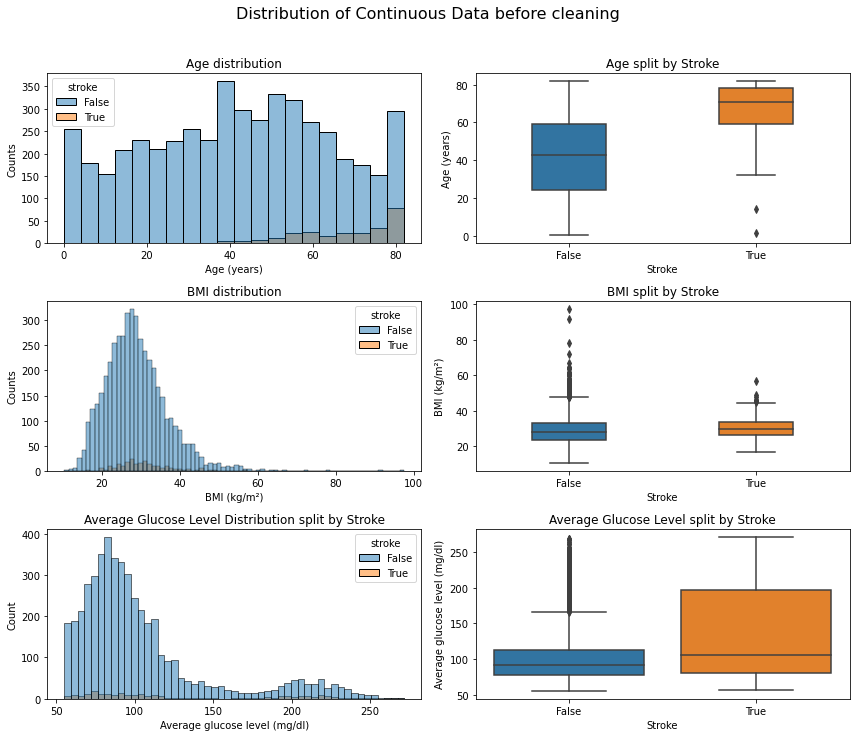

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Age distribution
sns.histplot(data=data, x='age', hue='stroke', ax=axes[0, 0])
axes[0, 0].set(xlabel='Age (years)', ylabel='Counts', title='Age distribution')

# Age split by Stroke
sns.boxplot(data=data, x='stroke', y='age', width=0.4, ax=axes[0, 1])
axes[0, 1].set(xlabel='Stroke', ylabel='Age (years)', title='Age split by Stroke')

# BMI distribution
sns.histplot(data=data, x='bmi', hue='stroke', ax=axes[1, 0])
axes[1, 0].set(xlabel='BMI (kg/m²)', ylabel='Counts', title='BMI distribution')

# BMI split by Stroke
sns.boxplot(data=data, x='stroke', y='bmi', width=0.4, ax=axes[1, 1])
axes[1, 1].set(xlabel='Stroke', ylabel='BMI (kg/m²)', title='BMI split by Stroke')

# Glucose Level distribution
sns.histplot(data, x = 'avg_glucose_level', hue = 'stroke', ax=axes[2, 0])
axes[2, 0].set(xlabel = 'Average glucose level (mg/dl)', ylabel = 'Count', title = 'Average Glucose Level Distribution split by Stroke')

# Glucose Level split by Stroke
sns.boxplot(data, x = 'stroke', y ='avg_glucose_level', ax=axes[2, 1])
axes[2, 1].set(xlabel = 'Stroke', ylabel = 'Average glucose level (mg/dl)', title = 'Average Glucose Level split by Stroke')


plt.suptitle('Distribution of Continuous Data before cleaning', fontsize=16, y=1.02)

plt.tight_layout()
plt.savefig('..\output\distribution_continuous_before.jpg', bbox_inches='tight')  # Save the figure with tight bounding box
plt.show()

#### Cleaning the Continuous Data

All the NaN Values of the Dataset are in the column 'BMI'
Since there are a lot of missing BMI values within the Stroke = True Data, we cannot just delet all these values. 
The missing values need to be adapted!!!

We want to predict the BMI values and for that this step will happen after encoding the data.

First we will take care of Outliers

### Missing BMI values problem

In [72]:
# Since there are a lot of missing BMI values within the Stroke = True Data, we cannot just delet all these values. 
# The missing values need to be adapted!!!

print(data.shape)
#data.dropna(axis='index', subset=['bmi'], inplace=True) #this command would delete missing values, what we don't want
#data['bmi'] = data['bmi'].fillna(data['bmi'].mean()) #this would fill the missing values with means

# BMI Prediction after scaling and encoding
print(data.shape)
# data.isna().sum()
#axis='index' -> rows containing missing values in the specified subset should be dropped
#inplace=True-> changes are made directly to the data DataFrame.

(5109, 11)
(5109, 11)


analyzing boxplots-> not only impossible values but also max/mins because not representative for population


In [73]:
#bmi: highest measured are around 200 so 100 is possible
print(data.shape)
print("-"*100)
filtered_data_bmi_f = data[(data['stroke'] == False) & (data['bmi'] >70)]
#print(filtered_data_bmi_f)
filtered_ids_bmi_f = filtered_data_bmi_f.index.tolist()
print("IDs that satisfy the bmi criteria without stroke:", filtered_ids_bmi_f)
data = data.drop(filtered_ids_bmi_f, axis=0)
print("-"*100)
print(data.shape)

filtered_data_bmi_t = data[(data['stroke'] == True) & (data['bmi'] >50)]
#print(filtered_data_bmi_t)
filtered_ids_bmi_t = filtered_data_bmi_t.index.tolist()
print("IDs that satisfy the bmi criteria with stroke:", filtered_ids_bmi_t)
data = data.drop(filtered_ids_bmi_t, axis=0)
print("-"*100)

#avg_glucose_level-> looks right/positive skewed, continuous values to the right-> no outliers detectable

#age: 2 outliers in the group stroke = True
print(data.shape)
print("-"*100)
filtered_data_age = data[(data['stroke'] == True) & (data['age'] < 30)]
#print(filtered_data_age)
#print('----------------------')
#num_ids = len(filtered_data)
#print(f"Number of IDs: {num_ids}")
#print('----------------------')
filtered_ids_age = filtered_data_age.index.tolist()
print("IDs that satisfy the age criteria:", filtered_ids_age)
data = data.drop(filtered_ids_age, axis=0)
print(data.shape)

(5109, 11)
----------------------------------------------------------------------------------------------------
IDs that satisfy the bmi criteria without stroke: [545, 41097, 56420, 51856]
----------------------------------------------------------------------------------------------------
(5105, 11)
IDs that satisfy the bmi criteria with stroke: [41069]
----------------------------------------------------------------------------------------------------
(5104, 11)
----------------------------------------------------------------------------------------------------
IDs that satisfy the age criteria: [69768, 49669]
(5102, 11)


do the bar plot again to see if outliers are gone

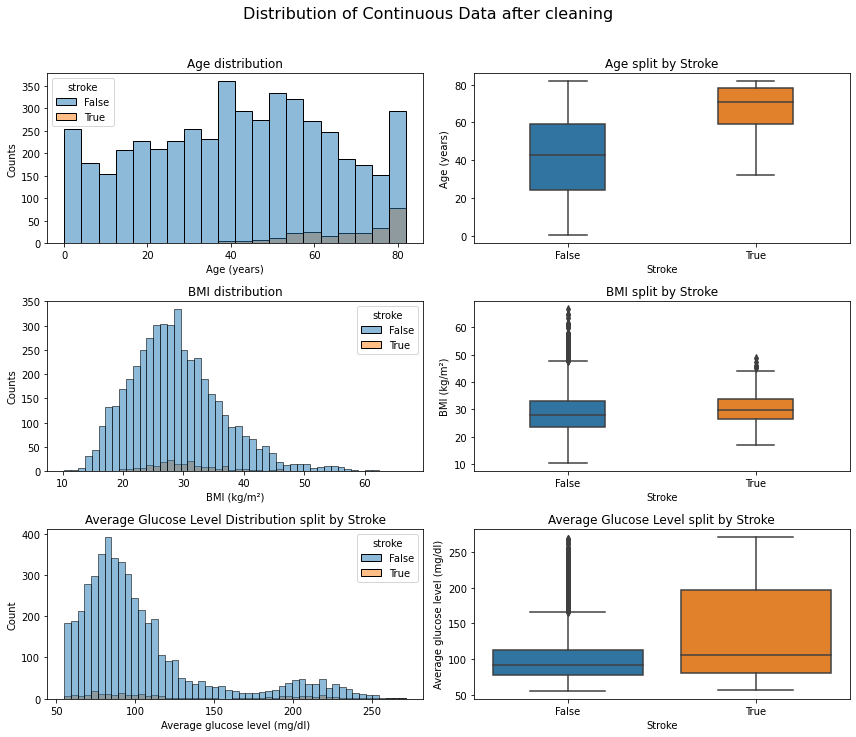

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Age distribution
sns.histplot(data=data, x='age', hue='stroke', ax=axes[0, 0])
axes[0, 0].set(xlabel='Age (years)', ylabel='Counts', title='Age distribution')

# Age split by Stroke
sns.boxplot(data=data, x='stroke', y='age', width=0.4, ax=axes[0, 1])
axes[0, 1].set(xlabel='Stroke', ylabel='Age (years)', title='Age split by Stroke')

# BMI distribution
sns.histplot(data=data, x='bmi', hue='stroke', ax=axes[1, 0])
axes[1, 0].set(xlabel='BMI (kg/m²)', ylabel='Counts', title='BMI distribution')

# BMI split by Stroke
sns.boxplot(data=data, x='stroke', y='bmi', width=0.4, ax=axes[1, 1])
axes[1, 1].set(xlabel='Stroke', ylabel='BMI (kg/m²)', title='BMI split by Stroke')

# Glucose Level distribution
sns.histplot(data, x = 'avg_glucose_level', hue = 'stroke', ax=axes[2, 0])
axes[2, 0].set(xlabel = 'Average glucose level (mg/dl)', ylabel = 'Count', title = 'Average Glucose Level Distribution split by Stroke')

# Glucose Level split by Stroke
sns.boxplot(data, x = 'stroke', y ='avg_glucose_level', ax=axes[2, 1])
axes[2, 1].set(xlabel = 'Stroke', ylabel = 'Average glucose level (mg/dl)', title = 'Average Glucose Level split by Stroke')


plt.suptitle('Distribution of Continuous Data after cleaning', fontsize=16, y=1.02)

plt.tight_layout()
plt.savefig('..\output\distribution_continuous_after.jpg', bbox_inches='tight')  # Save the figure with tight bounding box
plt.show()

## Scaling

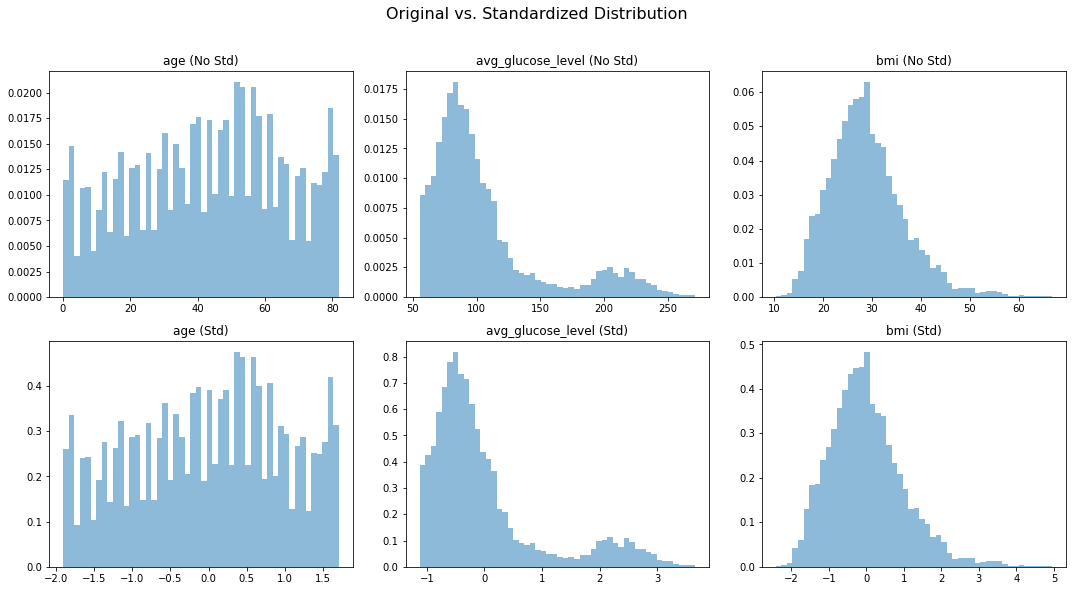

In [75]:
#standard scaler
sc = StandardScaler()

data_scaled = data.copy()

data_scaled[num_cols] = sc.fit_transform(data[num_cols])


# compare the three features before and after standardization
first_3_features = data[num_cols].iloc[:, :3].values
first_3_features_scaled = data_scaled[num_cols].iloc[:, :3].values
first_3_feature_names = num_cols[:3]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, feature_name in enumerate(first_3_feature_names):
    # Without standardization
    axes[0, i].hist(first_3_features[:, i], bins=50, density=True, alpha=0.5)
    axes[0, i].set_title("{} (No Std)".format(feature_name))

    # With standardization
    axes[1, i].hist(first_3_features_scaled[:, i], bins=50, density=True, alpha=0.5)
    axes[1, i].set_title("{} (Std)".format(feature_name))

plt.suptitle('Original vs. Standardized Distribution', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## One-Hot Encoding

One-hot encoding is used to convert categorical variables with multiple categories into binary vectors. Each category is represented by a binary column, where a value of 1 indicates the presence of the category and 0 represents the absence. One-hot encoding is suitable when there is no inherent ordinal relationship between the categories.

In [76]:
#Perform one-hot encoding on the categorical features
#One-hot encoding creates a new binary (0/1) column for each unique value in the categorical feature
df = pd.DataFrame(data)
print("Original dataset:")
display(df)

# One-hot encodeing of just the feature stroke:  
#encoded_df = pd.get_dummies(df, columns=['stroke'], prefix='stroke', drop_first=True)
#print("\nDataset with one-hot encoding of stroke:")
#display(encoded_df)

encoded_df = pd.get_dummies(data, columns=cate_cols, prefix = cate_cols, drop_first= True)
print("\nDataset with one-hot encoding:")
display(encoded_df)

Original dataset:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True
1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,True
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,True,False,Yes,Private,Urban,83.75,NaN,never smoked,False
44873,Female,81.0,False,False,Yes,Self-employed,Urban,125.20,40.0,never smoked,False
19723,Female,35.0,False,False,Yes,Self-employed,Rural,82.99,30.6,never smoked,False



Dataset with one-hot encoding:


,age,avg_glucose_level,bmi,stroke,gender_Male,hypertension_True,heart_disease_True,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,67.0,228.69,36.6,True,1,0,1,1,0,1,0,0,1,1,0,0
51676,61.0,202.21,NaN,True,0,0,0,1,0,0,1,0,0,0,1,0
31112,80.0,105.92,32.5,True,1,0,1,1,0,1,0,0,0,0,1,0
60182,49.0,171.23,34.4,True,0,0,0,1,0,1,0,0,1,0,0,1
1665,79.0,174.12,24.0,True,0,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,80.0,83.75,NaN,False,0,1,0,1,0,1,0,0,1,0,1,0
44873,81.0,125.20,40.0,False,0,0,0,1,0,0,1,0,1,0,1,0
19723,35.0,82.99,30.6,False,0,0,0,1,0,0,1,0,0,0,1,0


### BMI missing values prediction

In [77]:
# BMI Problem Prediction
# Split data into training and prediction sets
training_data = encoded_df[~encoded_df['bmi'].isna()]  # Rows with known BMI values
prediction_data = encoded_df[encoded_df['bmi'].isna()]  # Rows with NaN BMI values


# Check if there are any rows with missing BMI values
if prediction_data.empty:
    print("No rows with missing BMI values found.")
else:
    # Prepare training set
    features = ['age', 'gender_Male', 'hypertension_True', 'heart_disease_True', 'avg_glucose_level']
    target = 'bmi'
    X_train = training_data[features]
    y_train = training_data[target]

    # Create and train DecisionTreeRegressor
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Predict BMI values for NaN entries in the prediction set
    X_pred = prediction_data[features]
    predicted_bmi = model.predict(X_pred)

    # Assign predicted BMI values to the corresponding rows in the original dataset
    encoded_df.loc[encoded_df['bmi'].isna(), 'bmi'] = predicted_bmi

#encoded_df.isna().sum()

# to fill the missing BMI values also within the data set for further plotting tasks
if data.loc[data['bmi'].isna()].shape[0] > 0:
    data.loc[data['bmi'].isna(), 'bmi'] = predicted_bmi
#data.isna().sum()

# BMI visualization
# print(predicted_bmi)

### Correlation Heatmap

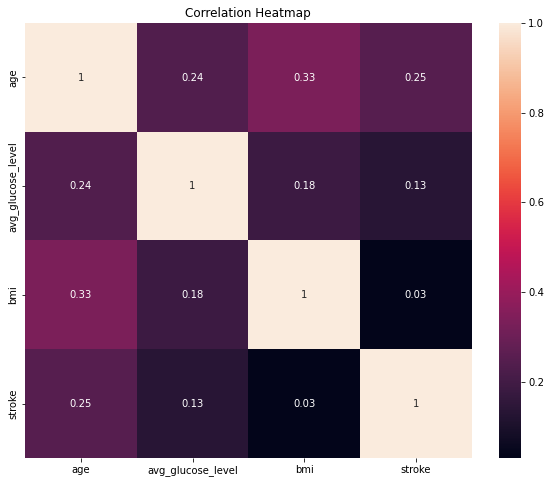

In [78]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

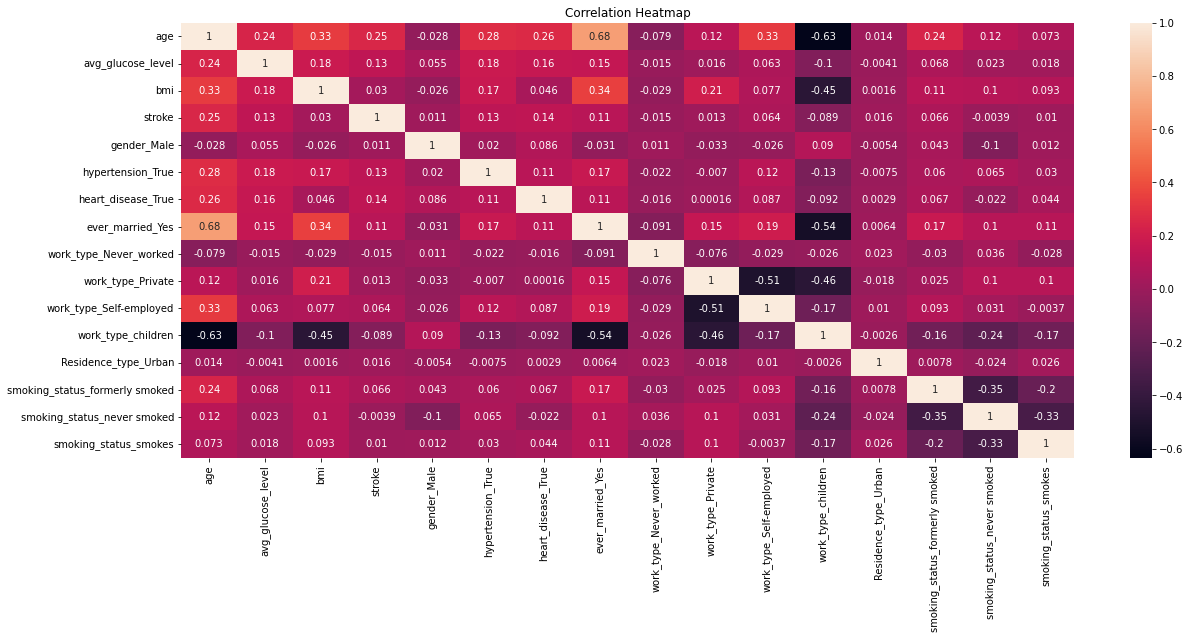

In [79]:
plt.figure(figsize=(20, 8))
sns.heatmap(encoded_df.corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()
#stroke in 4th line

## Feature selection

In [81]:
#Mutual information for FS for categorical output and categorical input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

selector_MI = SelectKBest(mutual_info_classif, k=5)
X_selected_MI = selector_MI.fit_transform(X,y)

selected_feature_indices_MI = selector_MI.get_support(indices=True)
selected_features_MI = X.columns[selected_feature_indices_MI]

print("Selected features MI: ", selected_features_MI)

Selected features MI:  Index(['age', 'avg_glucose_level', 'heart_disease_True', 'ever_married_Yes',
       'Residence_type_Urban'],
      dtype='object')


In [82]:
#Chi squared for FS for categorical output and categorical input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

selector_Chi = SelectKBest(chi2, k=5)
X_selected_Chi = selector_Chi.fit_transform(X,y)

selected_feature_indices_Chi = selector_Chi.get_support(indices=True)
selected_features_Chi = X.columns[selected_feature_indices_Chi]

print("Selected features Chi squared: ", selected_features_Chi)

Selected features Chi squared:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'heart_disease_True',
       'work_type_children'],
      dtype='object')


In [83]:
#ANOVA for FS for categorical output and numeric input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

selector_A = SelectKBest(f_classif, k=5)
X_selected_A = selector_A.fit_transform(X,y)

selected_feature_indices_A = selector_A.get_support(indices=True)
selected_features_A = X.columns[selected_feature_indices_A]

print("Selected features ANOVA: ", selected_features_A)

Selected features ANOVA:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'heart_disease_True',
       'ever_married_Yes'],
      dtype='object')


In [84]:
#Kendall's rank  for FS for categorical output and numeric input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

correlation_scores=[]
for feature in X.columns:
    correlation, _ = kendalltau(X[feature],y)
    correlation_scores.append(correlation)

selector_K = SelectKBest(k=5)
X_selected_K = selector_K.fit_transform(X,y)

selected_feature_indices_K = selector_K.get_support(indices=True)
selected_features_K = X.columns[selected_feature_indices_K]

print("Selected features Kendall's: ", selected_features_K)

Selected features Kendall's:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'heart_disease_True',
       'ever_married_Yes'],
      dtype='object')


##### Most important features: Age, Average Glucose Level, Hypertension, Heart Disease, Marriage, Work Type

## Test Split

In [85]:
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

# Split the data into training and test sets - the training set will be used for the cross-validation, while the test set is reserved to perform the overall evaluation in the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(y_train.sum())
print(y_test.sum())

197
49


### K-Fold Cross Validation -> we dont need this, only gridsearchcv!

In [86]:
"""
#this we dont need
# Create StratifiedKFold object for validation set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#we4
# Initialize lists to store performance metrics and selected features
precision_scores = []
recall_scores = []
selected_features = []
split = 1

# Iterate over each fold for validation set
for train_index, val_index in skf.split(X_train, y_train):

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Perform feature selection
    selector = SelectKBest(k=10)  # Choose the number of top features to select
    X_train_selected = selector.fit_transform(X_train_fold, y_train_fold)
    selected_features.append(selector.get_support(indices=True))
    X_val_selected = selector.transform(X_val_fold)

    # Perform hyperparameter selection using GridSearchCV for each model
    #ranking nach precision oder recall?-> RECALL weil alle erwischen
    #random state bei gridsearchcv überall gleich zwischen den modellen
    # Logistic Regression
    logreg = LogisticRegression()
    param_grid_logreg = {'C': [0.1, 1, 10]}
    grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, scoring='recall', cv=3)
    grid_search_logreg.fit(X_train_selected, y_train_fold)
    best_model_logreg = grid_search_logreg.best_estimator_

    # Random Forest
    rf = RandomForestClassifier()
    param_grid_rf = {'n_estimators': [100, 200, 300]}
    grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='recall', cv=3)
    grid_search_rf.fit(X_train_selected, y_train_fold)
    best_model_rf = grid_search_rf.best_estimator_

    # Support Vector Machine (SVM)
    svm = SVC()
    param_grid_svm = {'C': [0.1, 1, 10]}
    grid_search_svm = GridSearchCV(svm, param_grid_svm, scoring='recall', cv=3)
    grid_search_svm.fit(X_train_selected, y_train_fold)
    best_model_svm = grid_search_svm.best_estimator_

    # K-Nearest Neighbors (KNN)
    knn = KNeighborsClassifier()
    param_grid_knn = {'n_neighbors': [3, 5, 7]}
    grid_search_knn = GridSearchCV(knn, param_grid_knn, scoring='recall', cv=3)
    grid_search_knn.fit(X_train_selected, y_train_fold)
    best_model_knn = grid_search_knn.best_estimator_

    # Evaluate the best models on the validation set
    y_pred_logreg = best_model_logreg.predict(X_val_selected)
    y_pred_rf = best_model_rf.predict(X_val_selected)
    y_pred_svm = best_model_svm.predict(X_val_selected)
    y_pred_knn = best_model_knn.predict(X_val_selected)

    # Compute performance metrics for each model
    precision_scores.append([
        precision_score(y_val_fold, y_pred_logreg),
        precision_score(y_val_fold, y_pred_rf),
        precision_score(y_val_fold, y_pred_svm),
        precision_score(y_val_fold, y_pred_knn)
    ])

    recall_scores.append([
        recall_score(y_val_fold, y_pred_logreg),
        recall_score(y_val_fold, y_pred_rf),
        recall_score(y_val_fold, y_pred_svm),
        recall_score(y_val_fold, y_pred_knn)
    ])

    print("-"*100)
    print("Split Number", split)
    print("Logistic Regression Precision:", precision_score(y_val_fold, y_pred_logreg))
    print("Logistic Regression Recall:", recall_score(y_val_fold, y_pred_logreg))
    print("Random Forest Precision:", precision_score(y_val_fold, y_pred_rf))
    print("Random Forest Recall:", recall_score(y_val_fold, y_pred_rf))
    print("Support Vector Machine Precision:", precision_score(y_val_fold, y_pred_svm))
    print("Support Vector Machine Recall:", recall_score(y_val_fold, y_pred_svm))
    print("K-Nearest Neighbors Precision:", precision_score(y_val_fold, y_pred_knn))
    print("K-Nearest Neighbors Recall:", recall_score(y_val_fold, y_pred_knn))
    split += 1

# Print the performance metrics for each model
print("Precision scores:")
print(precision_scores)
print("Recall scores:")
print(recall_scores)

# Select the best features from all folds
final_selected_features = selector.get_support(indices=True) #final_selected_features = selector.get_support(indices=True): This line retrieves the indices of the selected features from the SelectKBest object, which represents the best features selected across all folds. It returns an array of indices indicating which features were selected as the best ones based on the scoring method used by SelectKBest. These indices can be used to extract the corresponding feature columns from your dataset.

# Select the best-performing feature set across all folds
#best_features = selected_features[np.argmax(precision_scores)] #best_features = selected_features[np.argmax(precision_scores)]: This line selects the best-performing feature set across all folds based on the precision scores calculated for each feature set. The selected_features list stores the indices of the selected features for each fold. The np.argmax() function returns the index of the maximum value from the precision_scores list, indicating the fold with the best precision score. The corresponding feature set indices from that fold are then accessed using selected_features[np.argmax(precision_scores)].

print("Selected features: (müesse mer no entschiede weles!!!!!)")
print(final_selected_features)

# Train the final model on the entire training set using the best features and hyperparameters
X_train_final_selected = X_train[:, final_selected_features]

# Logistic Regression
logreg = LogisticRegression(C=10)  # Use the best hyperparameters obtained from cross-validation
logreg.fit(X_train_final_selected, y_train)
y_pred_logreg = logreg.predict(X_test)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)

# Random Forest
rf = RandomForestClassifier()  # You can also specify the best hyperparameters obtained from cross-validation
rf.fit(X_train_final_selected, y_train)
y_pred_rf = rf.predict(X_test)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Support Vector Machine (SVM)
svm = SVC(C=10)  # Use the best hyperparameters obtained from cross-validation
svm.fit(X_train_final_selected, y_train)
y_pred_svm = svm.predict(X_test)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)

# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()  # You can also specify the best hyperparameters obtained from cross-validation
knn.fit(X_train_final_selected, y_train)
y_pred_knn = knn.predict(X_test)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)

# Print the final evaluation metrics for each model
print("Logistic Regression:")
print("Precision:", precision_logreg)
print("Recall:", recall_logreg)
print()
print("Random Forest:")
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print()
print("Support Vector Machine (SVM):")
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print()
print("K-Nearest Neighbors (KNN):")
print("Precision:", precision_knn)
print("Recall:", recall_knn)
"""

'\n#this we dont need\n# Create StratifiedKFold object for validation set\nskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n#we4\n# Initialize lists to store performance metrics and selected features\nprecision_scores = []\nrecall_scores = []\nselected_features = []\nsplit = 1\n\n# Iterate over each fold for validation set\nfor train_index, val_index in skf.split(X_train, y_train):\n\n    # Split the data into training and validation sets for the current fold\n    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]\n    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]\n\n    # Perform feature selection\n    selector = SelectKBest(k=10)  # Choose the number of top features to select\n    X_train_selected = selector.fit_transform(X_train_fold, y_train_fold)\n    selected_features.append(selector.get_support(indices=True))\n    X_val_selected = selector.transform(X_val_fold)\n\n    # Perform hyperparameter selection u

In [87]:
"""
metricsLR = {'precision': [], 'recall': [], 'f1': []}
metricsRF = {'precision': [], 'recall': [], 'f1': []}
metricsSVM = {'precision': [], 'recall': [], 'f1': []}
metricsKNN = {'precision': [], 'recall': [], 'f1': []}


X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_features = X_train[['age', 'avg_glucose_level', 'work_type_children']]
    X_test_features = X_test[['age', 'avg_glucose_level', 'work_type_children']]
    
    # Model 1: Logistic Regression
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train_features, y_train)
    logistic_regression_predictions = logistic_regression.predict(X_test_features)
    logistic_regression_precision = precision_score(y_test, logistic_regression_predictions)
    logistic_regression_recall = recall_score(y_test, logistic_regression_predictions)
    logistic_regression_f1 = f1_score(y_test, logistic_regression_predictions)
    
    metricsLR['precision'].append(logistic_regression_precision)
    metricsLR['recall'].append(logistic_regression_recall)
    metricsLR['f1'].append(logistic_regression_f1)

    # Model 2: Random Forest
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train_features, y_train)
    random_forest_predictions = random_forest.predict(X_test_features)
    random_forest_precision = precision_score(y_test, random_forest_predictions)
    random_forest_recall = recall_score(y_test, random_forest_predictions)
    random_forest_f1 = f1_score(y_test, random_forest_predictions)

    metricsRF['precision'].append(random_forest_precision)
    metricsRF['recall'].append(random_forest_recall)
    metricsRF['f1'].append(random_forest_f1)
    
    # Model 3: Support Vector Machine
    support_vector_machine = SVC()
    support_vector_machine.fit(X_train_features, y_train)
    support_vector_machine_predictions = support_vector_machine.predict(X_test_features)
    support_vector_machine_precision = precision_score(y_test, support_vector_machine_predictions)
    support_vector_machine_recall = recall_score(y_test, support_vector_machine_predictions)
    support_vector_machine_f1 = f1_score(y_test, support_vector_machine_predictions)

    metricsSVM['precision'].append(support_vector_machine_precision)
    metricsSVM['recall'].append(support_vector_machine_recall)
    metricsSVM['f1'].append(support_vector_machine_f1)

    # Model 4: K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(X_train_features, y_train)
    knn_predictions = knn.predict(X_test_features)
    knn_precision = precision_score(y_test, knn_predictions)
    knn_recall = recall_score(y_test, knn_predictions)
    knn_f1 = f1_score(y_test, knn_predictions)

    metricsKNN['precision'].append(knn_precision)
    metricsKNN['recall'].append(knn_recall)
    metricsKNN['f1'].append(knn_f1)
    # Print or store the performance metrics for each model
    print("Split Number", split)
    print("Logistic Regression Precision:", logistic_regression_precision)
    print("Logistic Regression Recall:", logistic_regression_recall)
    print("Logistic Regression F1:", logistic_regression_f1)
    print("Random Forest Precision:", random_forest_precision)
    print("Random Forest Recall:", random_forest_recall)
    print("Random Forest Recall F1:", random_forest_f1)

    print("Support Vector Machine Precision:", support_vector_machine_precision)
    print("Support Vector Machine Recall:", support_vector_machine_recall)
    print("Support Vector Machine F1:", support_vector_machine_f1)

    print("K-Nearest Neighbors Precision:", knn_precision)
    print("K-Nearest Neighbors Recall:", knn_recall)
    print("K-Nearest Neighbors F1:", knn_f1)

    split += 1
    print("-"*100)
"""


'\nmetricsLR = {\'precision\': [], \'recall\': [], \'f1\': []}\nmetricsRF = {\'precision\': [], \'recall\': [], \'f1\': []}\nmetricsSVM = {\'precision\': [], \'recall\': [], \'f1\': []}\nmetricsKNN = {\'precision\': [], \'recall\': [], \'f1\': []}\n\n\nX = encoded_df.drop(\'stroke\', axis=1)  # Features\ny = encoded_df[\'stroke\']  # Target variable (stroke)\n\nskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\nsplit = 1\n\nfor train_index, test_index in skf.split(X, y):\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    \n    X_train_features = X_train[[\'age\', \'avg_glucose_level\', \'work_type_children\']]\n    X_test_features = X_test[[\'age\', \'avg_glucose_level\', \'work_type_children\']]\n    \n    # Model 1: Logistic Regression\n    logistic_regression = LogisticRegression()\n    logistic_regression.fit(X_train_features, y_train)\n    logistic_regression_predictions = logistic_regre

# Statistical Analysis

Conduct statistical analyses to quantify relationships, assess significance, and make inferences about the data. This may involve calculating summary statistics, performing hypothesis testing, conducting regression analyses, or applying other statistical techniques as relevant to the data and goals.

Check if continuous variables are normally distributed - looking at the hisplots in Tutorial 3

Perform Shapiro-Wilk test for normality: P value larger than 0.05 -> normal distribution is assumed!  

In [88]:
#Check if continuous variables are normally distributed
#looking at the hisplots in Tutorial 3
#Perform Shapiro-Wilk test for normality
#P value larger than 0.05 -> normal distribution is assumed!  
columns = data.select_dtypes(include=[np.number]).columns
for var in columns:
    result = sts.shapiro(data[var].dropna())
    print(f"Shapiro-Wilk for {var}, p-value: {result.pvalue:.10f}")
#they are all NOT normally distributed-> take that into account later with alternative statistical techniques or distributions

Shapiro-Wilk for age, p-value: 0.0000000000
Shapiro-Wilk for avg_glucose_level, p-value: 0.0000000000
Shapiro-Wilk for bmi, p-value: 0.0000000000


they are all NOT normally distributed-> take that into account later with alternative statistical techniques or distributions

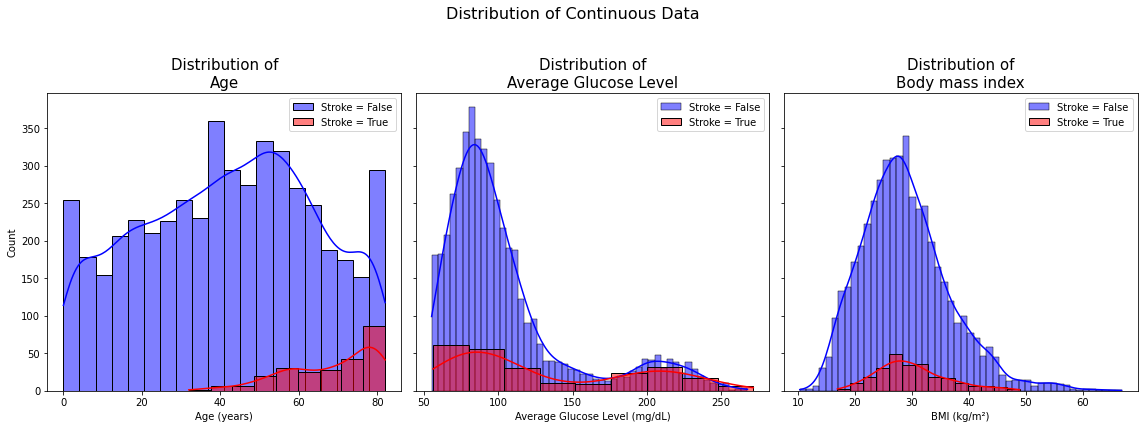

In [89]:
#plot the distributions of bmi, average glucose level and age
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(16, 10))
titles = {
    "age": "Age",
    "bmi": "Body mass index",
    "avg_glucose_level": "Average Glucose Level",
}
xlabels = {
    "age": "Age (years)",
    "bmi": "BMI (kg/m²)",
    "avg_glucose_level": "Average Glucose Level (mg/dL)",
}

for i, ax in enumerate(axs.flatten()):
    if i < len(numeric_columns):
        column = numeric_columns[i]
        sns.histplot(data=data[data['stroke'] == False], x=column, kde=True, ax=ax, color='blue', label='Stroke = False')
        sns.histplot(data=data[data['stroke'] == True], x=column, kde=True, ax=ax, color='red', label='Stroke = True')
        ax.set_title(f"Distribution of\n{titles[column]}", fontsize=15)
        ax.set_xlabel(xlabels[column], fontsize=10)
        ax.legend()
        if i != 0 and i != 3:
            ax.set_ylabel(None)
    else:
        fig.delaxes(ax)

plt.suptitle('Distribution of Continuous Data', fontsize=16, y=1.02)

fig.tight_layout()
plt.savefig('..\output\distribution_continuous.jpg')
plt.show()


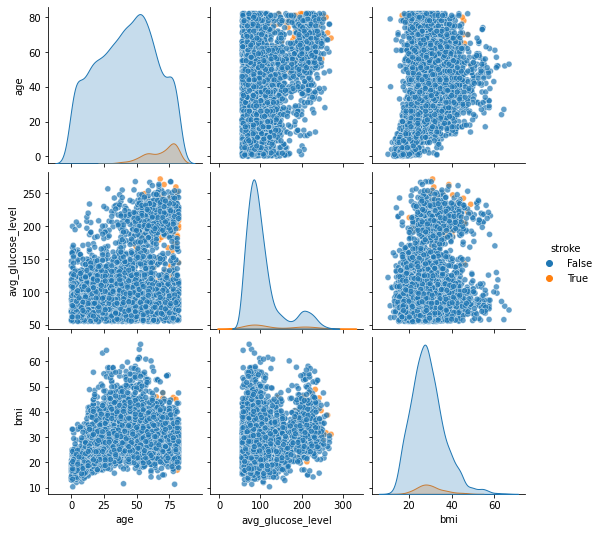

In [90]:
#correlation between variables
vars = data.select_dtypes(include=[np.number]).columns.tolist()
plot = sns.pairplot(data=data, vars=vars, hue="stroke", plot_kws={"alpha": 0.7, "marker": "o"})#plot_kws makes dots a little transparent
plot._legend.set_bbox_to_anchor((1, 0.5))  # Adjust legend position
plt.show()



In [91]:
#quantify correlation between variable pairs
for comb in combinations(vars, 2):
    print(f" {comb[0]} - {comb[1]}")
    print(f"\tSpearman Rank Correlation {sts.spearmanr(data[comb[0]], data[comb[1]]).statistic: .3f}, p-value {sts.spearmanr(data[comb[0]], data[comb[1]]).pvalue: .3f}")
    print(f"\tPearson Rank Correlation  {sts.pearsonr(data[comb[0]], data[comb[1]]).statistic: .3f}, p-value {sts.pearsonr(data[comb[0]], data[comb[1]]).pvalue: .3f}")
# Spearman:     is the Pearson’s correlation coefficient applied to the rank of the data, no absolute values but only relative ranks 
    #-1: perfect negative correlation (x increases, y decreases) 
    #0: no association (unrelated variables)  
    #+1: perfect positive correlation (x increases, y increases)   
#Pearson:     strength of the linear relationship between two variables (x, y) that come from interval or ratio level without outliers 
    #-1: perfect negative correlation (x increases, y decreases) 
    #0: no association (unrelated variables) 
    #+1: perfect positive correlation (x increases, y increases) 
    


 age - avg_glucose_level


AttributeError: 'SpearmanrResult' object has no attribute 'statistic'

In [ ]:
#statistical testing
#categorical variables, for example , and start with a contingency table by outcome.
#gender
gender_contingency = pd.crosstab(data["gender"],data["stroke"])
print(gender_contingency)
print("-"*100)
#smoking_status
smoking_status_contingency = pd.crosstab(data["smoking_status"],data["stroke"])
print(smoking_status_contingency)
print("-"*100)
#ever_married
ever_married_contingency = pd.crosstab(data["ever_married"],data["stroke"])
print(ever_married_contingency)
print("-"*100)
#work_type
work_type_contingency = pd.crosstab(data["work_type"],data["stroke"])
print(work_type_contingency)
print("-"*100)
#Residence_type
Residence_type_contingency = pd.crosstab(data["Residence_type"],data["stroke"])
print(Residence_type_contingency)
print("-"*100)

In [ ]:
#such a contingency table provides the basis for a chi squared test.
chi2_result_gender = sts.chi2_contingency(gender_contingency)
print(chi2_result_gender)
chi2_result_smoking_status = sts.chi2_contingency(smoking_status_contingency)
print(chi2_result_smoking_status)
chi2_result_ever_married = sts.chi2_contingency(ever_married_contingency)
print(chi2_result_ever_married)
chi2_result_work_type = sts.chi2_contingency(work_type_contingency)
print(chi2_result_work_type)
chi2_result_Residence_type = sts.chi2_contingency(Residence_type_contingency)
print(chi2_result_Residence_type)

In [ ]:
print('P-value of Chi-Squared-Test by gender:',chi2_result_gender.pvalue)

print('P-value of Chi-Squared-Test by smoking status:',chi2_result_smoking_status.pvalue) 
#statistically significant->smoking status is likely associated with stroke 

print('P-value of Chi-Squared-Test by marriage:',chi2_result_ever_married.pvalue)
#statistically significant->marriage is likely associated with stroke 

print('P-value of Chi-Squared-Test by type of work:',chi2_result_work_type.pvalue)
#statistically significant->type of work is likely associated with stroke 

print('P-value of Chi-Squared-Test by type of residence:',chi2_result_Residence_type.pvalue)


# Modeling and Predictive Analytics

Apply appropriate models and algorithms to make predictions or derive insights from the data. This step includes selecting suitable models, training them on the data, evaluating their performance, and refining the models as needed.

In [92]:
#this function which will create a table at the end of the four machine learning tools to sumarize the evaluation metrics on the test and training sets
#the evaluation matrics are stored in "df_performance"

def eval_Performance(y_eval, X_eval, clf, clf_name = 'My Classifier'):

    y_pred = clf.predict(X_eval)
    y_pred_proba = clf.predict_proba(X_eval)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred).ravel()

    # Evaluation
    accuracy  = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall    = recall_score(y_eval, y_pred)
    f1        = f1_score(y_eval, y_pred)
    fp_rates, tp_rates, _ = roc_curve(y_eval, y_pred_proba)

    # Calculate the area under the roc curve using a sklearn function
    roc_auc = auc(fp_rates, tp_rates)

    return tp,fp,tn,fn,accuracy, precision, recall, f1, roc_auc

#here our values will be stroed
df_performance = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'f1', 'roc_auc'] )


## Logistic Regression

In [97]:
# Define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # Regularization penalty
    'C': [0.1, 1.0, 10.0], # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs']
}
class_weights = 'balanced'

# Create a Logistic Regression with balanced class weights
logistic_regression = LogisticRegression(class_weight='balanced', random_state=42)

# Create a GridSearchCV object with logistic regression and the parameter grid
grid_search = GridSearchCV(logistic_regression, param_grid, scoring='recall', cv=5)

# Fit the grid search to the training data using the 5 best features stored in 'selected_features_MI'
grid_search.fit(X_train[selected_features_MI], y_train)

# Get the best estimator (model) and its hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the Logistic regression with the best hyperparameters and balanced class weights
best_lr_model = LogisticRegression(class_weight='balanced', random_state=42, **best_params)

# Fit the model on the training data using the 5 best selected features
best_lr_model.fit(X_train[selected_features_MI], y_train)

# Evaluate the model on the test set to predict values and evaluate how good its prediction was (this is just done once and at the end after fitting our model)
y_pred_test = best_lr_model.predict(X_test[selected_features_MI])

# Print classification report
print(classification_report(y_test, y_pred_test))

# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features_MI], best_lr_model, clf_name='LR')

# Store the values in a dataframe or table
df_performance.loc['LR (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['LR (train)', :] = eval_Performance(y_train, X_train[selected_features_MI], best_lr_model, clf_name='LR (train)')
df_performance

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

       False       0.99      0.74      0.84       972
        True       0.13      0.80      0.23        49

    accuracy                           0.74      1021
   macro avg       0.56      0.77      0.53      1021
weighted avg       0.95      0.74      0.81      1021



,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
LR (test),39,257,715,10,0.738492,0.131757,0.795918,0.226087,0.848891
LR (train),162,1049,2835,35,0.734379,0.133774,0.822335,0.230114,0.848633
RF (test),1,9,963,48,0.944172,0.1,0.020408,0.033898,0.71586
RF (train),197,0,3884,0,1.0,1.0,1.0,1.0,1.0


## Random Forest

In [94]:
##Reminders:
#die besten features sind als selected_features_MI gespeichert
#X = encoded_df.drop('stroke', axis=1)  # Features
#y = encoded_df['stroke']  # Target variable (stroke)
# Split the data into training and test sets - the training set will be used for the cross-validation, while the test set is reserved to perform the overall evaluation in the end
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [95]:
# Define the parameter grid in order to find the best hyperparameters for my Random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']}

# Create a Random Forest classifier with balanced class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the grid search object with the RF classifier and parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)

# Fit the grid search object to the training data using our 5 best features stored in "selected_features_MI"
grid_search.fit(X_train[selected_features_MI], y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the Random Forest classifier with the best hyperparameters and balanced class weights
best_rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)

# Fit the model on the training data using the 5 best selected features
best_rf_model.fit(X_train[selected_features_MI], y_train)

# Evaluate the model on the test set to predict values and evaluate how good its prediction was (this is just done once and at the end after fitting our model)
y_pred_test = best_rf_model.predict(X_test[selected_features_MI])

# Print classification report
print(classification_report(y_test, y_pred_test))

# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features_MI], best_rf_model, clf_name='RF')

# Store the values in a dataframe or table
df_performance.loc['RF (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['RF (train)', :] = eval_Performance(y_train, X_train[selected_features_MI], best_rf_model, clf_name='RF (train)')
df_performance


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

       False       0.95      0.99      0.97       972
        True       0.10      0.02      0.03        49

    accuracy                           0.94      1021
   macro avg       0.53      0.51      0.50      1021
weighted avg       0.91      0.94      0.93      1021



,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
LR (test),39,257,715,10,0.738492,0.131757,0.795918,0.226087,0.848891
LR (train),162,1049,2835,35,0.734379,0.133774,0.822335,0.230114,0.848633
RF (test),1,9,963,48,0.944172,0.1,0.020408,0.033898,0.71586
RF (train),197,0,3884,0,1.0,1.0,1.0,1.0,1.0


### Other Parameters

### RF Noemie Versuech

In [ ]:
# Instantiate the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10)

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Get feature importance scores
importance_scores = rf_classifier.feature_importances_

# Create a pandas Series with feature names and their importance scores
feature_importance = pd.Series(importance_scores, index=X_train.columns)

# Sort the features by their importance scores
sorted_feature_importance = feature_importance.sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importance.values, y=sorted_feature_importance.index)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

# Perform grid search
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

# Train the final model with the best parameters
final_rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
final_rf_classifier.fit(X_train, y_train)



## Support Vector Machines

In [ ]:
# Instantiate the SVM Classifier
svm = SVC(kernel='linear', C=1.0)

# Training the Model
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)


In [ ]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)

# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


In [ ]:
# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features_MI], best_rf_model, clf_name='SVM')

# Store the values in a dataframe or table
df_performance.loc['SVM (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['SVM (train)', :] = eval_Performance(y_train, X_train[selected_features_MI], best_rf_model, clf_name='SVM (train)')
df_performance

## K-Nearest Neighbour

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 4: Data Normalization/Standardization
#def normalize_data(X_train, X_test):
#    scaler = StandardScaler()
#    X_train = scaler.fit_transform(X_train)
#    X_test = scaler.transform(X_test)
#    return X_train, X_test

# Step 5: Choosing the Value of k based on precision
def select_best_k(X_train, y_train, X_test, y_test, max_k):
    k_values = list(range(1, max_k + 1))
    accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plotting the elbow curve
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Neighbors (k)')
    plt.show()

    best_k = k_values[np.argmax(accuracies)]
    return best_k

# Step 4: Data Normalization/Standardization
#X_train, X_test = normalize_data(X_train, X_test)

# Step 5: Choosing the Best Value of k
max_k = 20  # Maximum value of k to consider
best_k = select_best_k(X_train, y_train, X_test, y_test, max_k)
print("Best k:", best_k)

# Step 6: Training the Model
def train_knn(X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train, y_train)
    return knn

knn_model = train_knn(X_train, y_train)

# Step 7: Prediction and Evaluation
#accuracy, precision, recall, f1 = evaluate_model(knn_model, X_test, y_test)

# Print the evaluation metrics
#print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1-score:", f1)
#df_performance_knn_test = eval_Performance(y_test, X_test, knn_model, clf_name = 'KNN (test)')
#df_performance_knn_train = eval_Performance(y_train, X_train, knn_model, clf_name = 'KNN (train)')
df_performance.loc['KNN (train)',:] = eval_Performance(y_train, X_train, knn_model, clf_name = 'KNN (train)')
df_performance.loc['KNN (test)',:] = eval_Performance(y_test, X_test, knn_model, clf_name = 'KNN (test)')
df_performance

In [ ]:
# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features_MI], best_rf_model, clf_name='KNN')

# Store the values in a dataframe or table
df_performance.loc['KNN (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['KNN (train)', :] = eval_Performance(y_train, X_train[selected_features_MI], best_rf_model, clf_name='KNN (train)')
df_performance

In [ ]:
# summary of the four machine learning tools 

In [ ]:
df_performance

## Overview Presentation

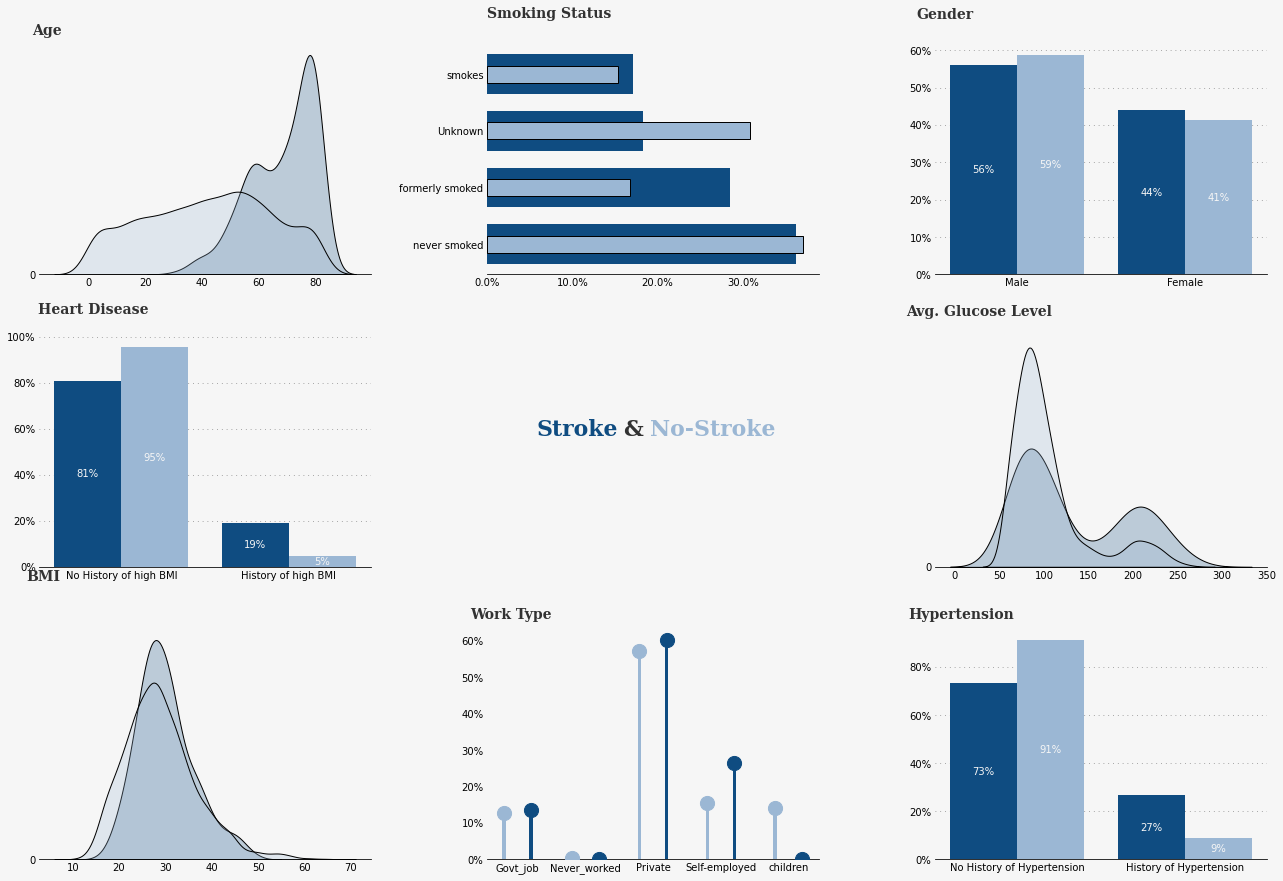

In [96]:
import matplotlib.ticker as mtick
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color


# Plots

## Age


ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])
sns.kdeplot(positive["age"], ax=ax0,color="#0f4c81", shade=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#9bb7d4", shade=True, ec='black',label="negative")
#ax3.text(0.29, 13, 'Age', 
 #        fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")



# Smoking
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#0f4c81", zorder=3, height=0.7)
ax1.barh(negative.index, negative['Percentage'], color="#9bb7d4", zorder=3,ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
# Ax2 - GENDER 
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["gender"].apply(lambda x: x/sum(positive["gender"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["gender"].apply(lambda x: x/sum(negative["gender"])*100)

x = np.arange(len(positive))
ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

    

# Heart Disease
positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))
ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['No History of high BMI','History of high BMI'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    

## Title
ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

ax4.text(0.15,0.57,"Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#0f4c81')
ax4.text(0.41,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.49,0.57,"No-Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#9bb7d4')


# Glucose level
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5,color="#0f4c81",ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#9bb7d4", ec='black',shade=True, label="negative")
ax5.text(-55, 0.01855, 'Avg. Glucose Level', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')    
ax5.set_xlabel('')



# BMI
ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#0f4c81", ec='black',shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#9bb7d4",ec='black', shade=True, label="negative")
ax6.text(-0.06, 0.09, 'BMI', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')    
ax6.set_xlabel('')


# Work Type
positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#9bb7d4")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#0f4c81")

ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")



# Hypertension
positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History of Hypertension','History of Hypertension'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

        
plt.show()